In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

2025-08-26 17:11:35.086303: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-26 17:11:35.089152: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-26 17:11:35.096072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756249895.106692   58634 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756249895.109718   58634 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-26 17:11:35.122615: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
#======================== set up ============================
# get parameter information
with open(utils_dir+"/param_names.pkl", "rb") as f:
    param_info = pickle.load(f)
u_params = param_info['u_params']
pft_params = param_info['pft_params']

# get biome information
with open("./biome_configs.pkl", "rb") as f:
    biome_configs = pickle.load(f)


# get default parameter set and reset some settings of default parameters
default_params = pd.read_csv('default_params_norm.csv', index_col=False)
default_params.loc[0, ['jmaxb1']] = [0.4]
default_params.loc[0, ['theta_cj']] = [0.7]
default_params.loc[0, ['upplim_destruct_metamorph']] = [1]
default_params.loc[0, ['xl_12']] = [0]
default_params.loc[0, ['TAU']] = [0.7]
default_params.loc[0, ['RF_SS']] = [0.3]

default_params.loc[0,['leafcn_12']] = [0.9831]
default_params.loc[0,['slatop_12']] = [0.0315]

default_params.loc[0,['leafcn_11']] = [0.9984]
default_params.loc[0,['slatop_11']] = [0.0315]

default_params.loc[0,['KCN_14']] = [0]


In [3]:
# get observations
obs_biome = xr.open_dataset('calibration_obsStatistics_sudokuBiomes.nc')

In [4]:
# get observations
obs_biome = xr.open_dataset('calibration_obsStatistics_sudokuBiomes_r5.nc')

# adjust calibration targets 
# tropical rainforest # because coupled model has dry bias in amazon
obs_biome.LAI_mean.loc[dict(biome=1)] = (obs_biome.LAI_max-obs_biome.LAI_mean).isel(biome=1).values/2 + obs_biome.LAI_mean.isel(biome=1).values
obs_biome.LAI_stdev.loc[dict(biome=1)]= (obs_biome.LAI_max-obs_biome.LAI_mean).isel(biome=1).values/2

obs_biome.GPP_mean.loc[dict(biome=1)] = (obs_biome.GPP_max-obs_biome.GPP_mean).isel(biome=1).values/2 + obs_biome.GPP_mean.isel(biome=1).values
obs_biome.GPP_stdev.loc[dict(biome=1)]= (obs_biome.GPP_max-obs_biome.GPP_mean).isel(biome=1).values/2


# mixed decid temperate forest
obs_biome.LAI_mean.loc[dict(biome=7)] = 1.4*obs_biome.LAI_min.isel(biome=7).values


### load calibrated sets

In [4]:
# if starting from a checkpoint
with open("./checkpoints_objective_v3/checkpoint_step_500.pkl", "rb") as f:
    check = pickle.load(f)
params = check['params'].numpy()
universal_params = np.tile(default_params[u_params].iloc[[0]].to_numpy(),(len(params),1))
master_params = np.concatenate([universal_params,params],axis=1)
cal_params = pd.DataFrame(master_params, columns = default_params.columns)

2025-08-26 17:12:22.531122: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Emulate to check

In [5]:
key = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/ctsm6lhc_11262024.txt'
params = pd.read_csv(key).drop(columns='member')

infile = '/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/ctsm6lhc_pxbmean_sudoku3_1985-2023.nc'
ds_lhc = xr.open_dataset(infile)

# drop crashers
lhc_pxb = ds_lhc.where(ds_lhc['crashed'] != 1, drop=True)
ix = np.where(ds_lhc.crashed==1)[0]
params_lhc = params.drop(ix-1)

lai_lhc = lhc_pxb.TLAI_biome_amax.sel(year=slice('2001','2020')).mean(dim='year').compute()
gpp_lhc = (60*60*24)*lhc_pxb.GPP_biome_amean.sel(year=slice('2001','2015')).mean(dim='year').compute()
tvc_lhc = (1/1000)*lhc_pxb.TOTVEGC_biome_amean.sel(year=slice('2000','2019')).mean(dim='year').compute()

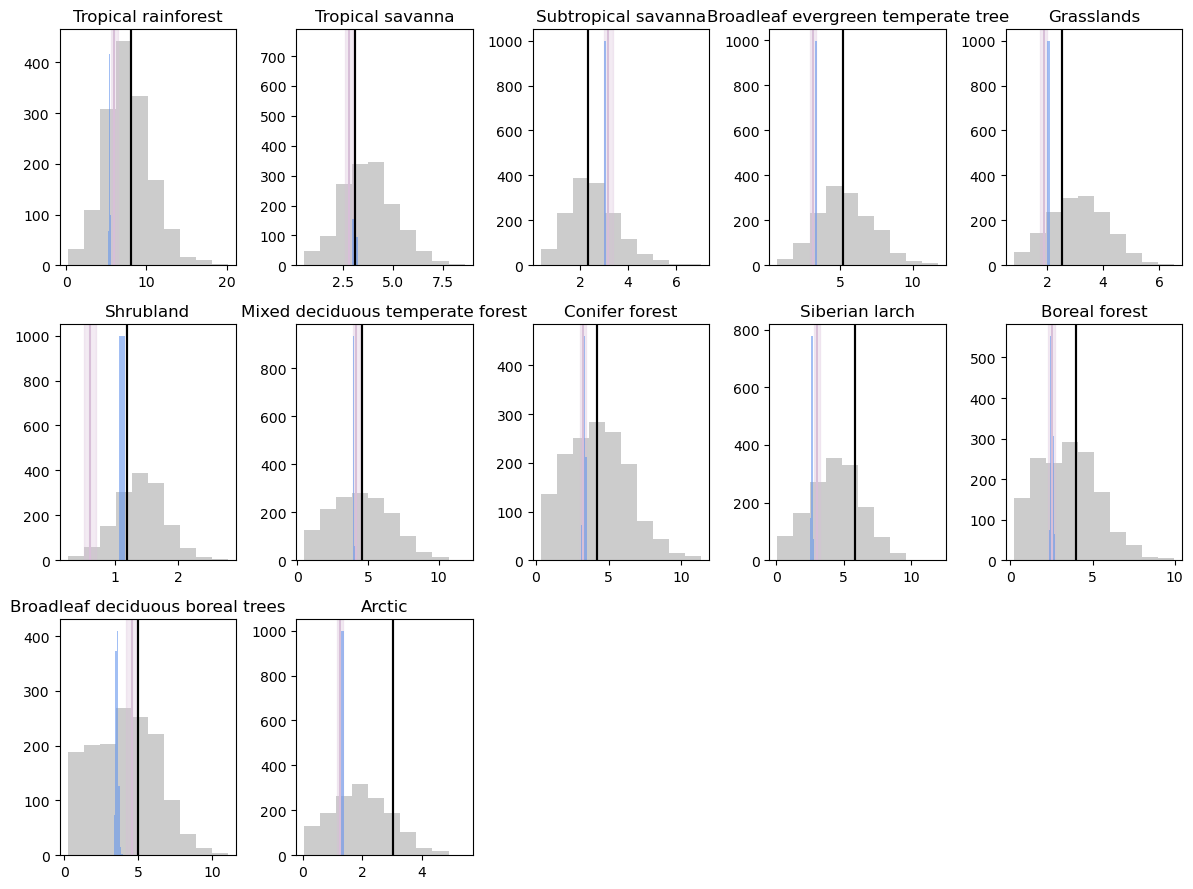

In [9]:
emulator_dir = './emulators_biomelai_compiled/'

plt.figure(figsize=(12,9))
for b,biome in enumerate(biome_configs[1:],start=1):
    biome_name = biome['name']
    plt.subplot(3,5,b)

    obs_mean = obs_biome.LAI_mean.sel(biome=b).values
    obs_std = obs_biome.LAI_stdev.sel(biome=b).values
    obs_max = obs_biome.LAI_max.sel(biome=b).values
    obs_min = obs_biome.LAI_min.sel(biome=b).values

    pfts = biome['pfts']
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = cal_params[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome_name)
    y_pred, y_pred_var = loaded_emulator.compiled_predict_f(samp)

    plt.hist(lai_lhc.isel(biome=b),color='grey',alpha=0.4,density=False)
    plt.axvspan(obs_mean-1*obs_std,obs_mean+1*obs_std,color='thistle',alpha=0.3)
    #plt.axvspan(obs_min,obs_max,color='cadetblue',alpha=0.3)
    plt.axvline(obs_mean,color='thistle')
    plt.axvline(lai_lhc.isel(ens=0,biome=b),color='k')
    plt.axvline(lai_lhc.isel(biome=b,ens=0),color='k')
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue',density=False,bins=np.arange(y_pred.numpy().flatten().min(), y_pred.numpy().flatten().max() + 0.1, 0.1))
    
    plt.title(biome_name)

plt.tight_layout()
plt.savefig('./checkpoints_objective/CalCheck_LAI.png')

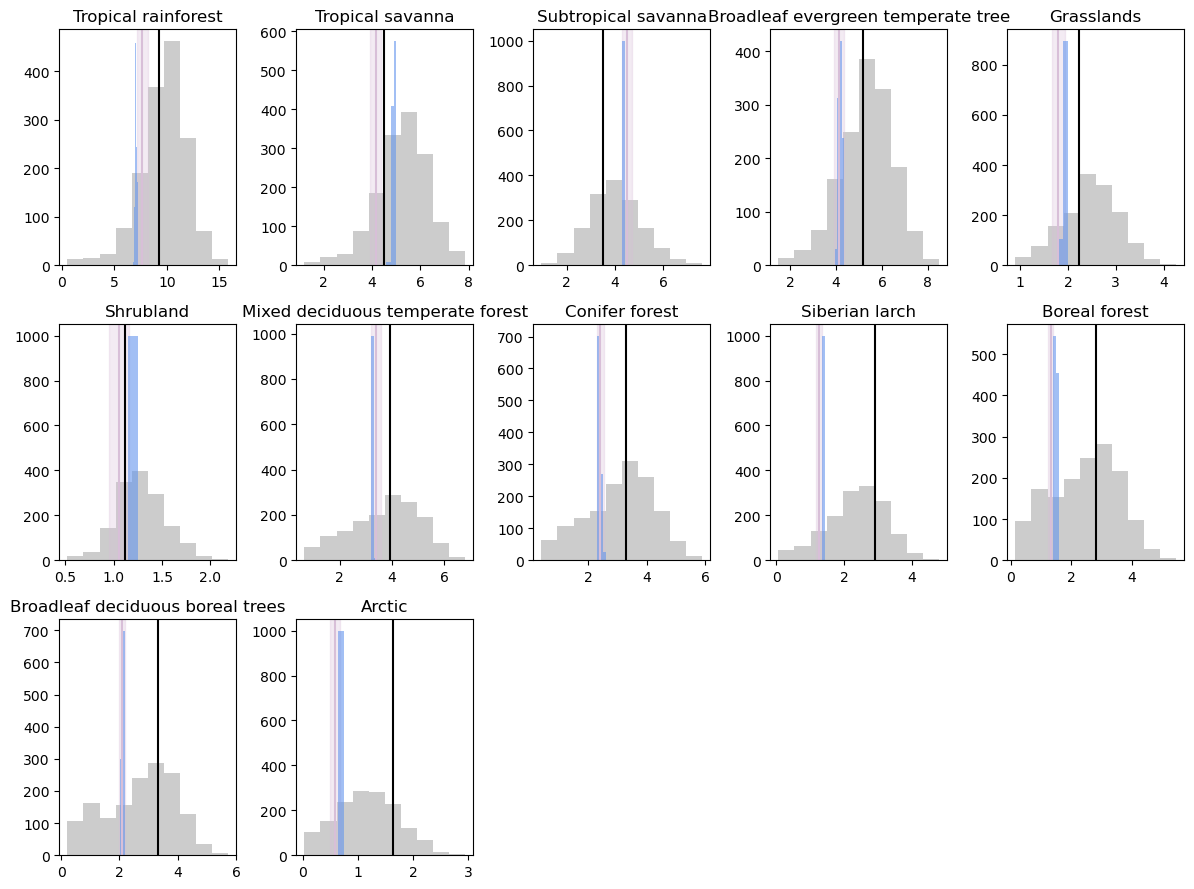

In [10]:
emulator_dir = './emulators_biomegpp_compiled/'

plt.figure(figsize=(12,9))
for b,biome in enumerate(biome_configs[1:],start=1):
    biome_name = biome['name']
    plt.subplot(3,5,b)

    obs_mean = obs_biome.GPP_mean.sel(biome=b).values
    obs_var = obs_biome.GPP_stdev.sel(biome=b).values**2

    pfts = biome['pfts']
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = cal_params[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome_name)
    y_pred, y_pred_var = loaded_emulator.compiled_predict_f(samp)

    plt.hist(gpp_lhc.isel(biome=b),color='grey',alpha=0.4,density=False)
    plt.axvspan(obs_mean-1*obs_var**0.5,obs_mean+1*obs_var**0.5,color='thistle',alpha=0.3)
    #plt.axvspan(obs_biome.GPP_min.sel(biome=b).values,obs_biome.GPP_max.sel(biome=b).values,color='cadetblue',alpha=0.3)
    plt.axvline(obs_mean,color='thistle')
    plt.axvline(gpp_lhc.isel(ens=0,biome=b),color='k')
    #plt.axvline(y_pred.numpy().flatten(),color='green')
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue',density=False,bins=np.arange(y_pred.numpy().flatten().min(), y_pred.numpy().flatten().max() + 0.1, 0.1))
    
    plt.title(biome_name)

plt.tight_layout()
plt.savefig('./checkpoints_objective/CalCheck_GPP.png')

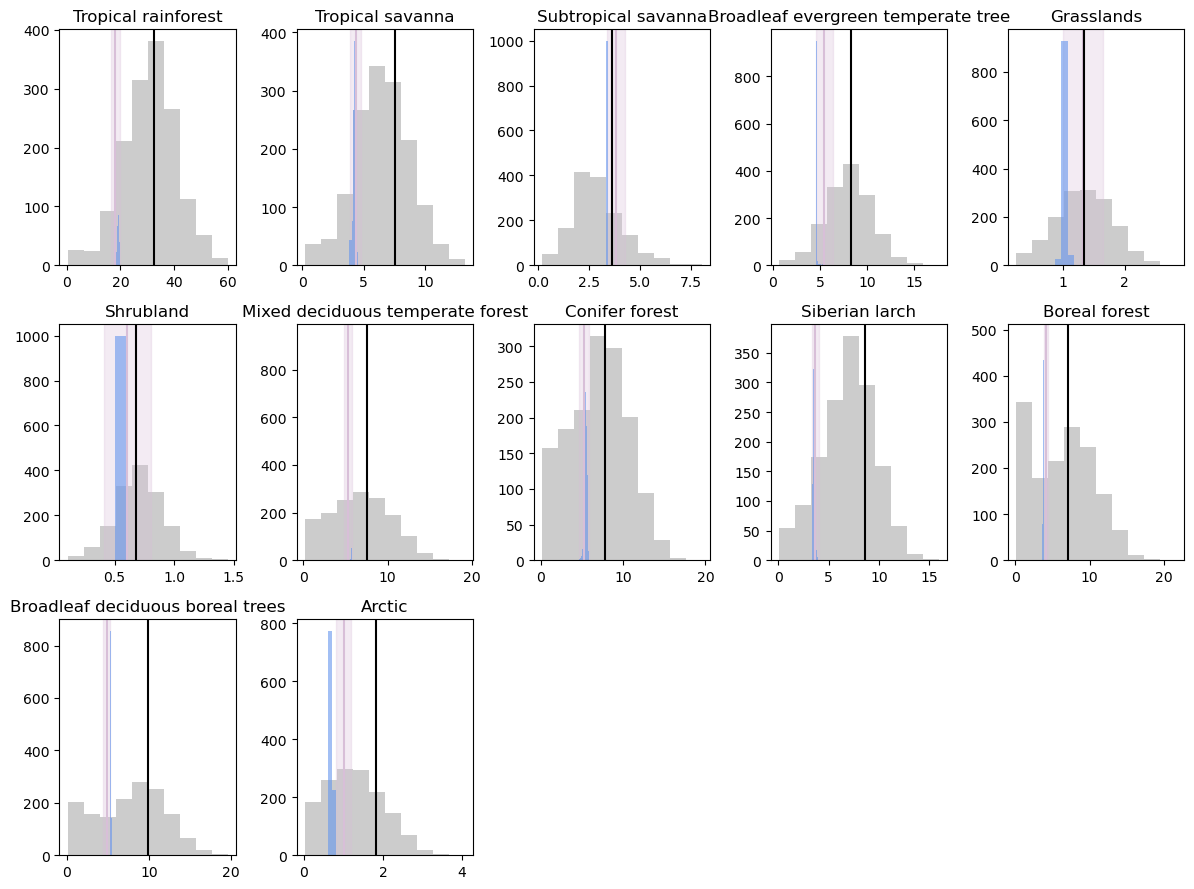

In [12]:
emulator_dir = './emulators_biomebiomass_compiled/'

plt.figure(figsize=(12,9))
for b,biome in enumerate(biome_configs[1:],start=1):
    biome_name = biome['name']
    plt.subplot(3,5,b)

    obs_mean = obs_biome.TVC_mean.sel(biome=b).values
    obs_var = obs_biome.TVC_stdev.sel(biome=b).values**2

    pfts = biome['pfts']
    cols = u_params
    for p in pfts:
        param_names = [f"{param}_{p}" for param in pft_params]
        cols = np.concatenate([cols,param_names])
    
    samp = cal_params[cols]
    
    loaded_emulator = tf.saved_model.load(emulator_dir + biome_name)
    y_pred, y_pred_var = loaded_emulator.compiled_predict_f(samp)

    plt.hist(tvc_lhc.isel(biome=b),color='grey',alpha=0.4,density=False)
    plt.axvspan(obs_mean-1*obs_var**0.5,obs_mean+1*obs_var**0.5,color='thistle',alpha=0.3)
    #plt.axvspan(obs_biome.TVC_min.sel(biome=b).values,obs_biome.TVC_max.sel(biome=b).values,color='cadetblue',alpha=0.3)
    plt.axvline(obs_mean,color='thistle')
    plt.axvline(tvc_lhc.isel(biome=b,ens=0),color='k')
    plt.hist(y_pred.numpy().flatten(),alpha = 0.6,color='cornflowerblue',density=False,bins=np.arange(y_pred.numpy().flatten().min(), y_pred.numpy().flatten().max() + 0.1, 0.1))
    
    plt.title(biome_name)

plt.tight_layout()
plt.savefig('./checkpoints_objective/CalCheck_biomass.png')

### Plot posteriors

/glade/derecho/scratch/linnia/tmp/ipykernel_58634/2377468857.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/glade/derecho/scratch/linnia/tmp/ipykernel_58634/2377468857.py:41: UserWarning: 
The palette list has fewer values (1) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(
/glade/derecho/scratch/linnia/tmp/ipykernel_58634/2377468857.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/glade/derecho/scratch/linnia/tmp/ipykernel_58634/2377468857.py:41: UserWarning: 
The palette list has fewer values (1) than needed (13) and will cycle, which may produce an uninterpretable plot.
  sns.violinplot(
/glade/derecho/scratch/linnia/tmp/

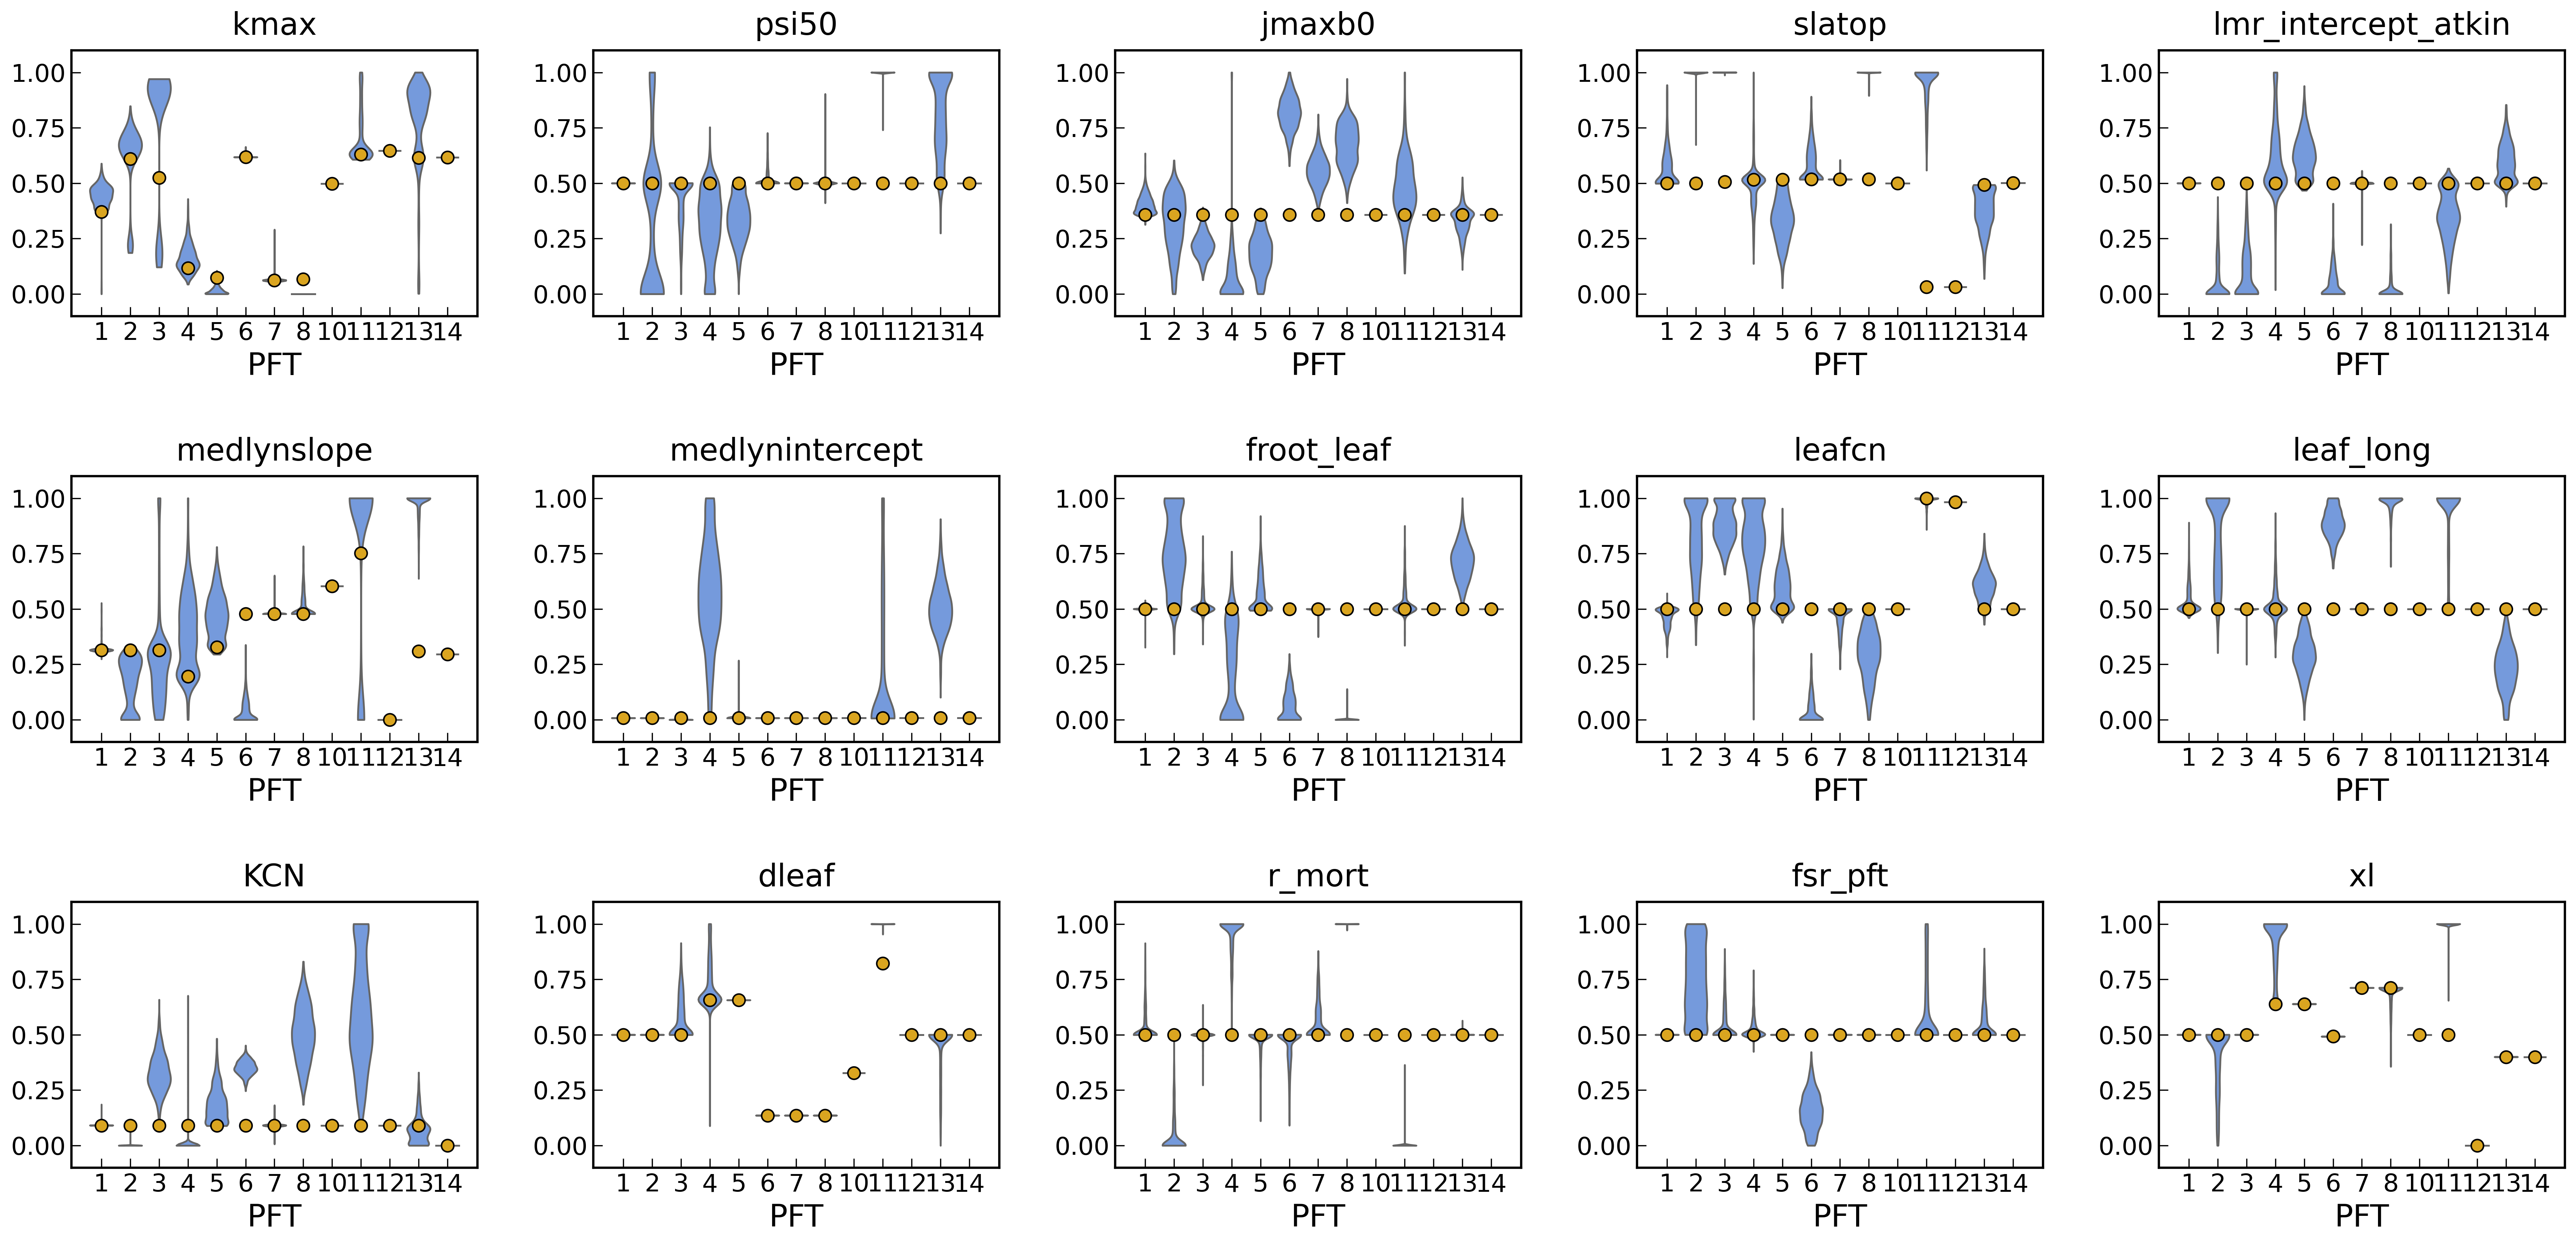

In [15]:
import seaborn as sns
import matplotlib as mpl

# Set publication quality style
mpl.rcParams.update({
    "font.size": 18,
    "axes.labelsize": 20,
    "axes.titlesize": 22,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "legend.fontsize": 16,
    "axes.linewidth": 1.5,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
    "axes.grid": False,
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "figure.facecolor": "white"
})

plt.figure(figsize=(24, 12))
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]
n_params = len(pft_params)
ncols = 5
nrows = int(np.ceil(n_params / ncols))

for j, param in enumerate(pft_params):
    ax = plt.subplot(nrows, ncols, j+1)
    pft_param_names = [f"{param}_{pft}" for pft in pft_ids]
    data = cal_params[pft_param_names]

    # Prepare data for seaborn violinplot
    plot_data = data.melt(var_name="PFT", value_name="Value")
    plot_data["PFT"] = plot_data["PFT"].apply(lambda x: int(x.split("_")[-1]))

    # Violin plot
    sns.violinplot(
        x="PFT", y="Value", data=plot_data, 
        order=pft_ids, 
        palette=["cornflowerblue"], 
        cut=0, 
        inner=None, 
        linewidth=1.2, 
        ax=ax
    )

    # Overlay default values
    for i, pft in enumerate(pft_ids):
        col = f"{param}_{pft}"
        if col in default_params:
            ax.plot(i, default_params[col], 'o', color='goldenrod', markersize=8, markeredgecolor='k', zorder=10)

    ax.set_ylim([-0.1, 1.1])
    ax.set_xticks(range(len(pft_ids)))
    ax.set_xticklabels(pft_ids, rotation=0)
    ax.set_title(param, fontsize=20, pad=10)
    ax.set_xlabel("PFT")
    #if j % ncols == 0:
        #ax.set_ylabel("Parameter Value")
    #else:
    ax.set_ylabel("")

plt.tight_layout(pad=2.0)
plt.savefig('./checkpoints_objective/posteriors_byParam.png', dpi=300, bbox_inches='tight')

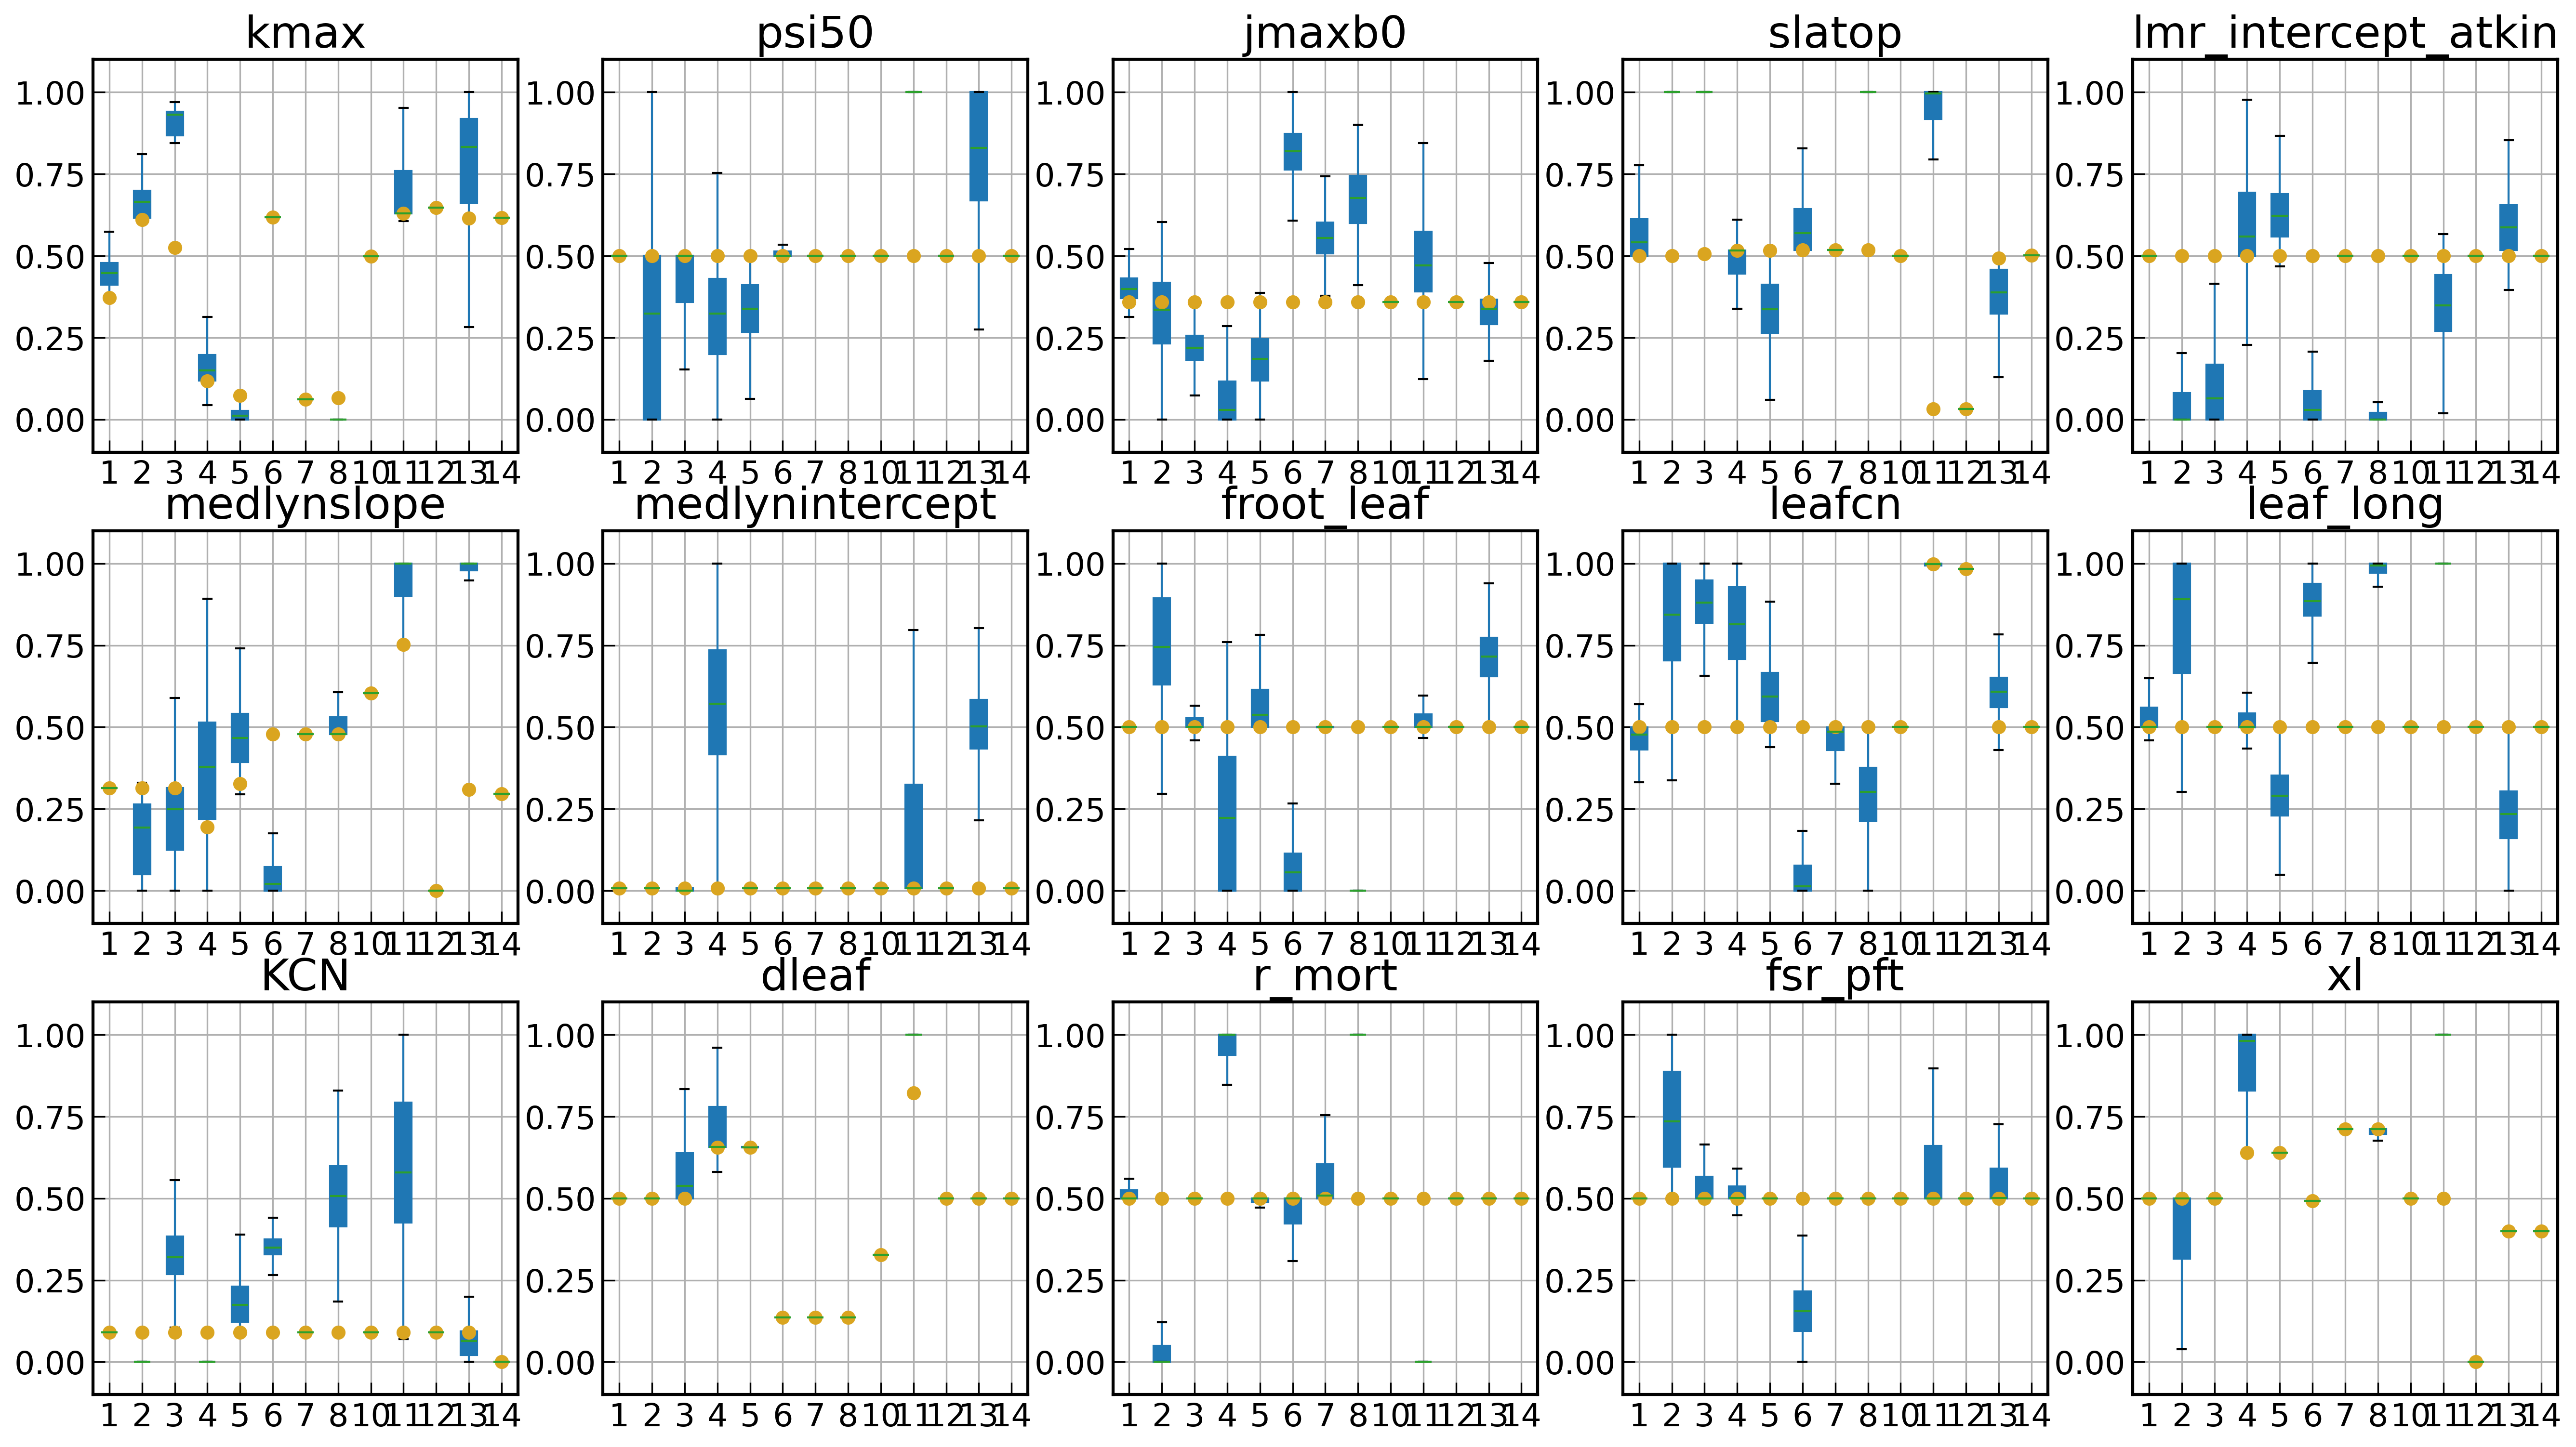

In [16]:
plt.figure(figsize=(22, 12))
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]

for j, param in enumerate(pft_params):
    plt.subplot(3, 5, j+1)
    pft_param_names = [f"{param}_{pft}" for pft in pft_ids]
    data = cal_params[pft_param_names]
    
    ax = plt.gca()
    data.boxplot(showfliers=False, patch_artist=True, ax=ax)

    # Style the boxes
    for patch in ax.artists:
        patch.set_facecolor('cornflowerblue')
        patch.set_edgecolor('cornflowerblue')

    # Overlay default values
    for i, col in enumerate(data.columns):
        plt.plot(i + 1, default_params[col], 'o', color='goldenrod')  # x is 1-based
    plt.ylim([-0.1,1.1])

    plt.xticks(ticks=np.arange(1, len(data.columns) + 1), labels=pft_ids, rotation=0)
    plt.title(param)
plt.savefig('./checkpoints_objective/posteriors_byParam_box.png', dpi=200)

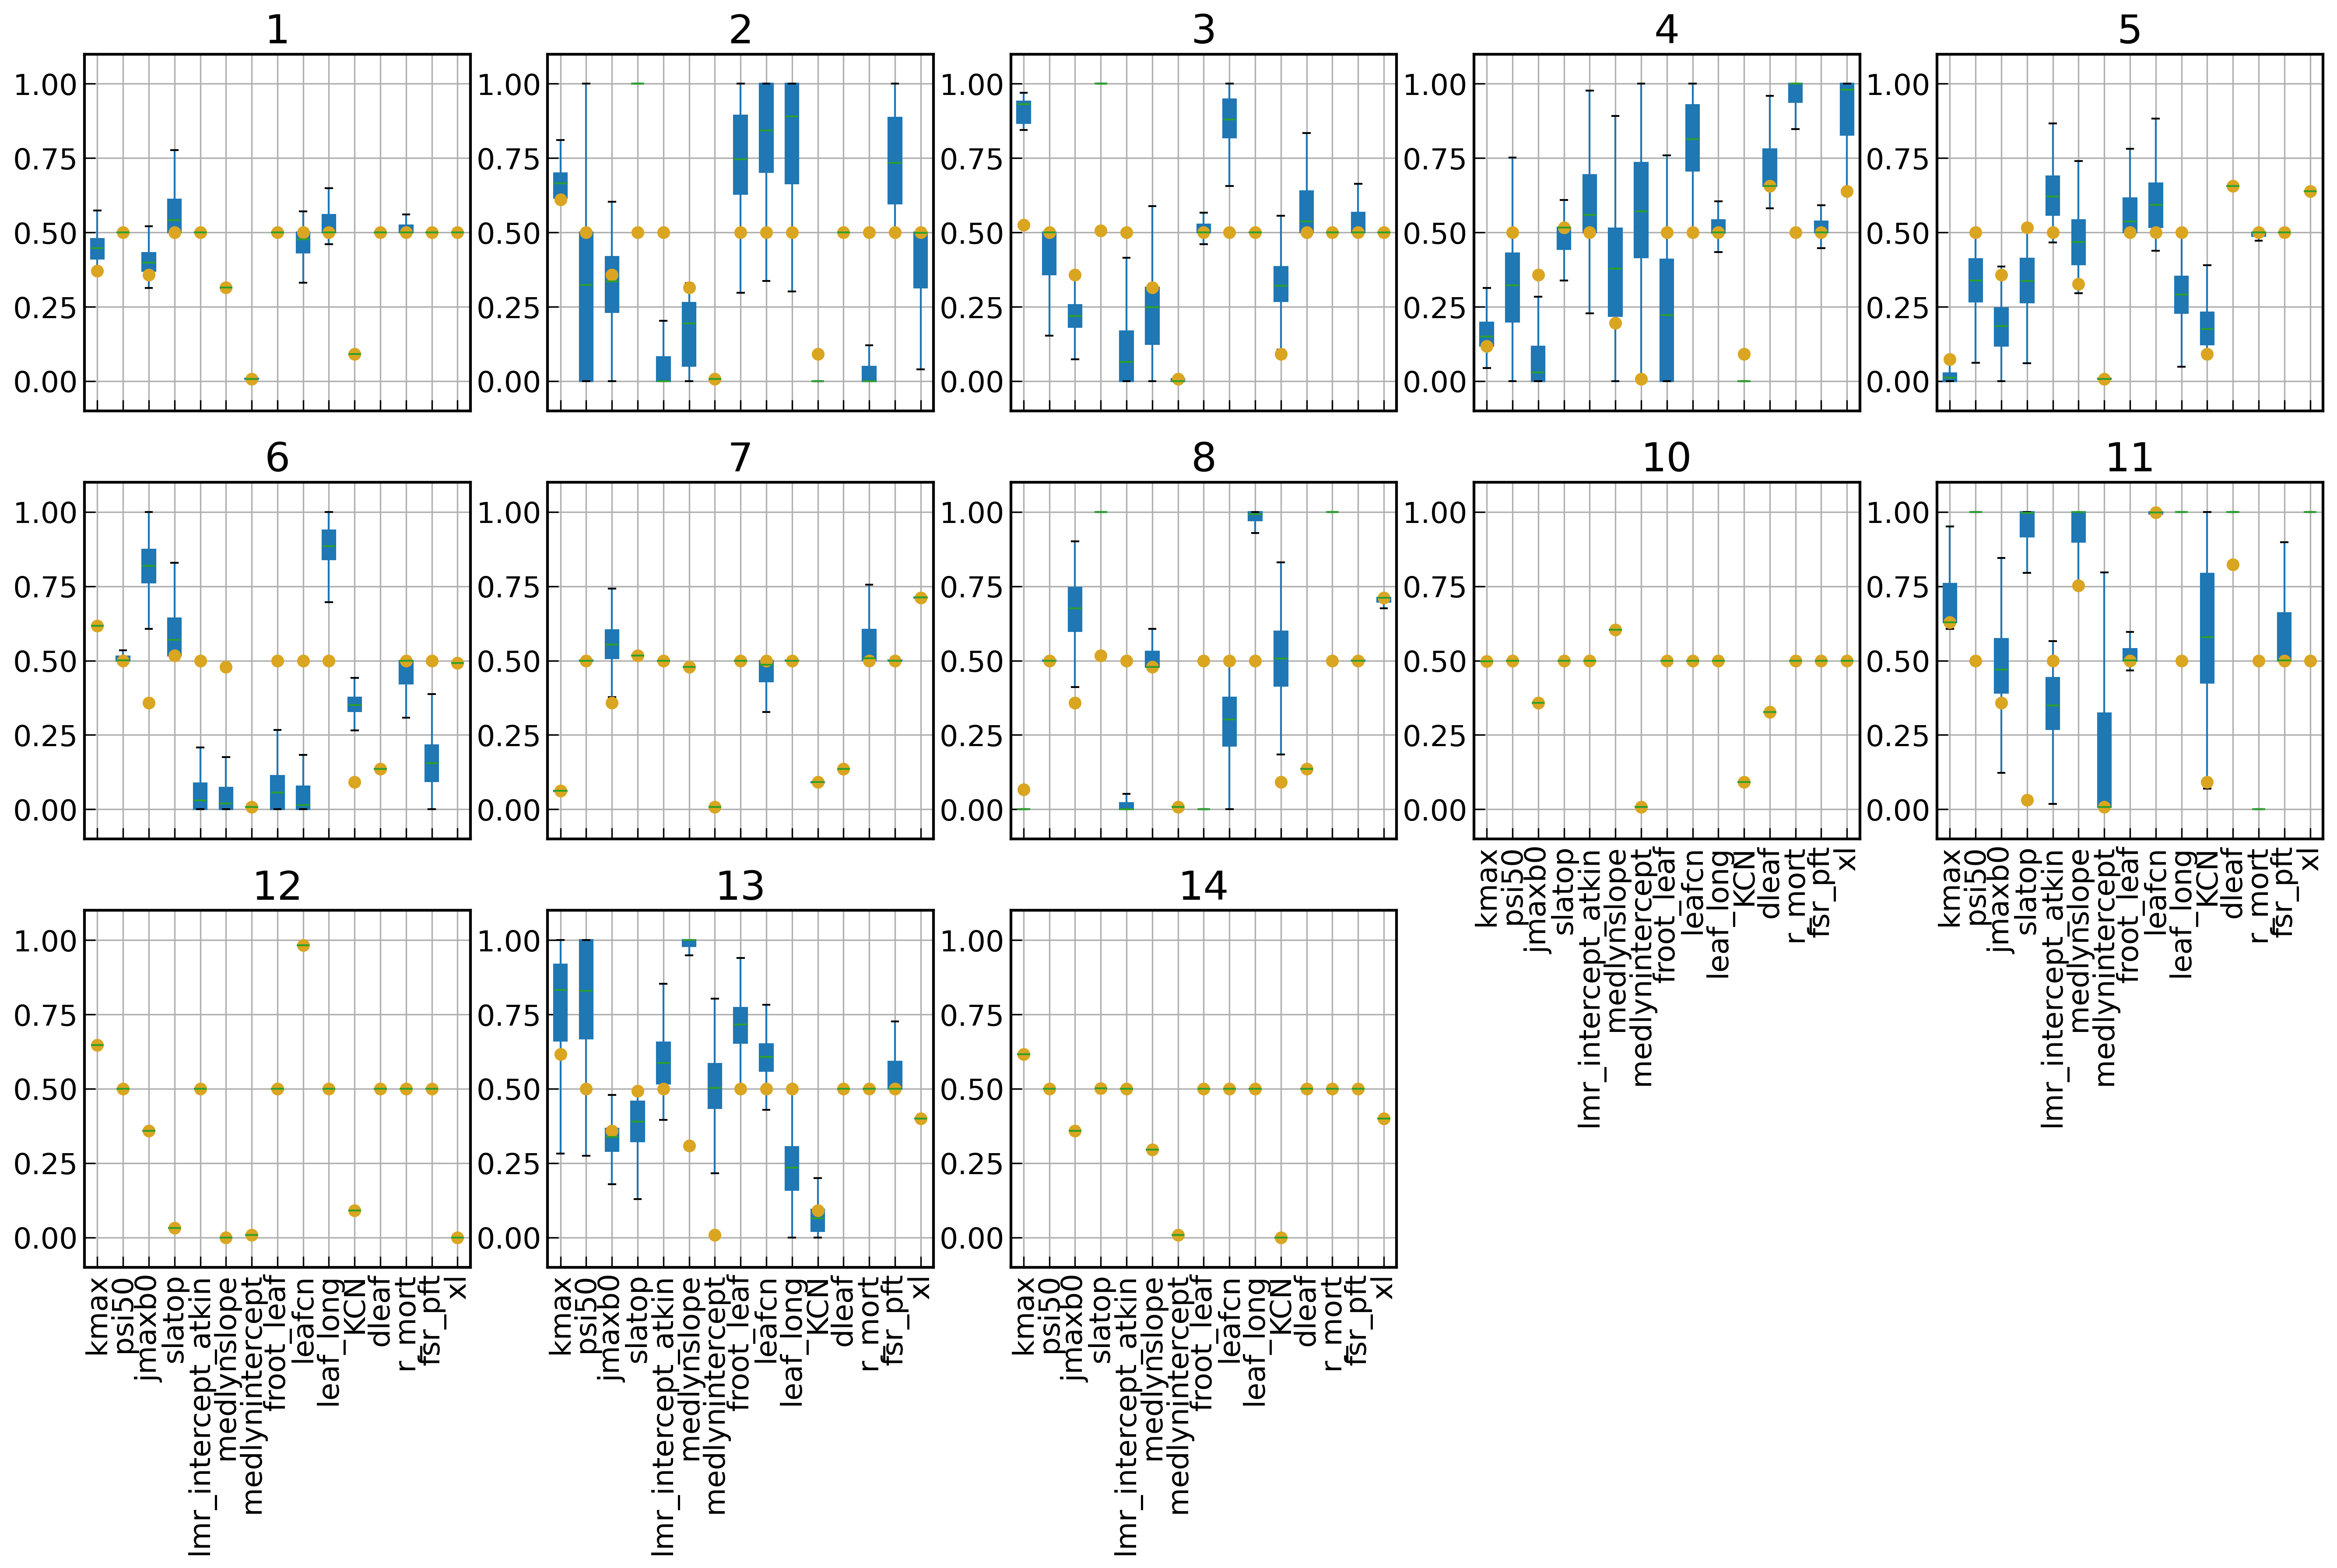

In [17]:
plt.figure(figsize=(22, 12))
pft_ids = [1,2,3,4,5,6,7,8,10,11,12,13,14]

for j, pft in enumerate(pft_ids):
    plt.subplot(3, 5, j+1)
    pft_param_names = [f"{param}_{pft}" for param in pft_params]
    data = cal_params[pft_param_names]
    
    ax = plt.gca()
    data.boxplot(showfliers=False, patch_artist=True, ax=ax)

    # Style the boxes
    for patch in ax.artists:
        patch.set_facecolor('cornflowerblue')
        patch.set_edgecolor('cornflowerblue')

    # Overlay default values
    for i, col in enumerate(data.columns):
        plt.plot(i + 1, default_params[col], 'o', color='goldenrod')  # x is 1-based

    if pft>8:
        plt.xticks(ticks=np.arange(1, len(data.columns) + 1), labels=pft_params, rotation=90)
    else:
        plt.xticks(ticks=np.arange(1, len(data.columns) + 1),labels=[])

    plt.ylim([-0.1,1.1])
    plt.title(pft)
plt.savefig('./checkpoints_objective/posteriors_byPFT_box.png', dpi=200)

### Cluster across other metrics

In [ ]:
from sklearn.cluster import KMeans
import itertools
from sklearn.preprocessing import StandardScaler

In [19]:
paths = {
    'vcmx25z': './emulators_global/vcmx25z',
    'cue': './emulators_global/cue/',
    'ncost': './emulators_global/ncost/',
    'alloc': './emulators_global/alloc/',
    'wstress': './emulators_global/wstress/',
}

vars = ['vcmx25z','cue','ncost','alloc','wstress']
out_data = {var: [] for var in vars}

cols = default_params.columns
samp = cal_params[cols]

for var in vars:
    emulator = tf.saved_model.load(f"{paths[var]}")
    y_pred, _ = emulator.predict(samp)
    out_data[var].append(y_pred.numpy().squeeze())


In [20]:
# Now convert to Dataset
n_samp = out_data[vars[0]][0].shape[0]
samples = np.arange(n_samp)

ds_vars = {}
for var in vars:
    data_array = out_data[var][0]
    ds_vars[var] = (['sample'], data_array)

ds = xr.Dataset(ds_vars, coords={'sample': samples})


In [22]:
#(n_samples, n_vars)
nClusters=5
X = np.stack([
    ds['vcmx25z'].values,
    ds['cue'].values,
    ds['ncost'].values,
    ds['alloc'].values,
    ds['wstress'].values
], axis=1)

# Normalize 
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

# Cluster the samples
kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(X_norm)
labels = kmeans.labels_  # shape: (n_samples,)

# add to dataset
ds['cluster'] = ('sample', labels)

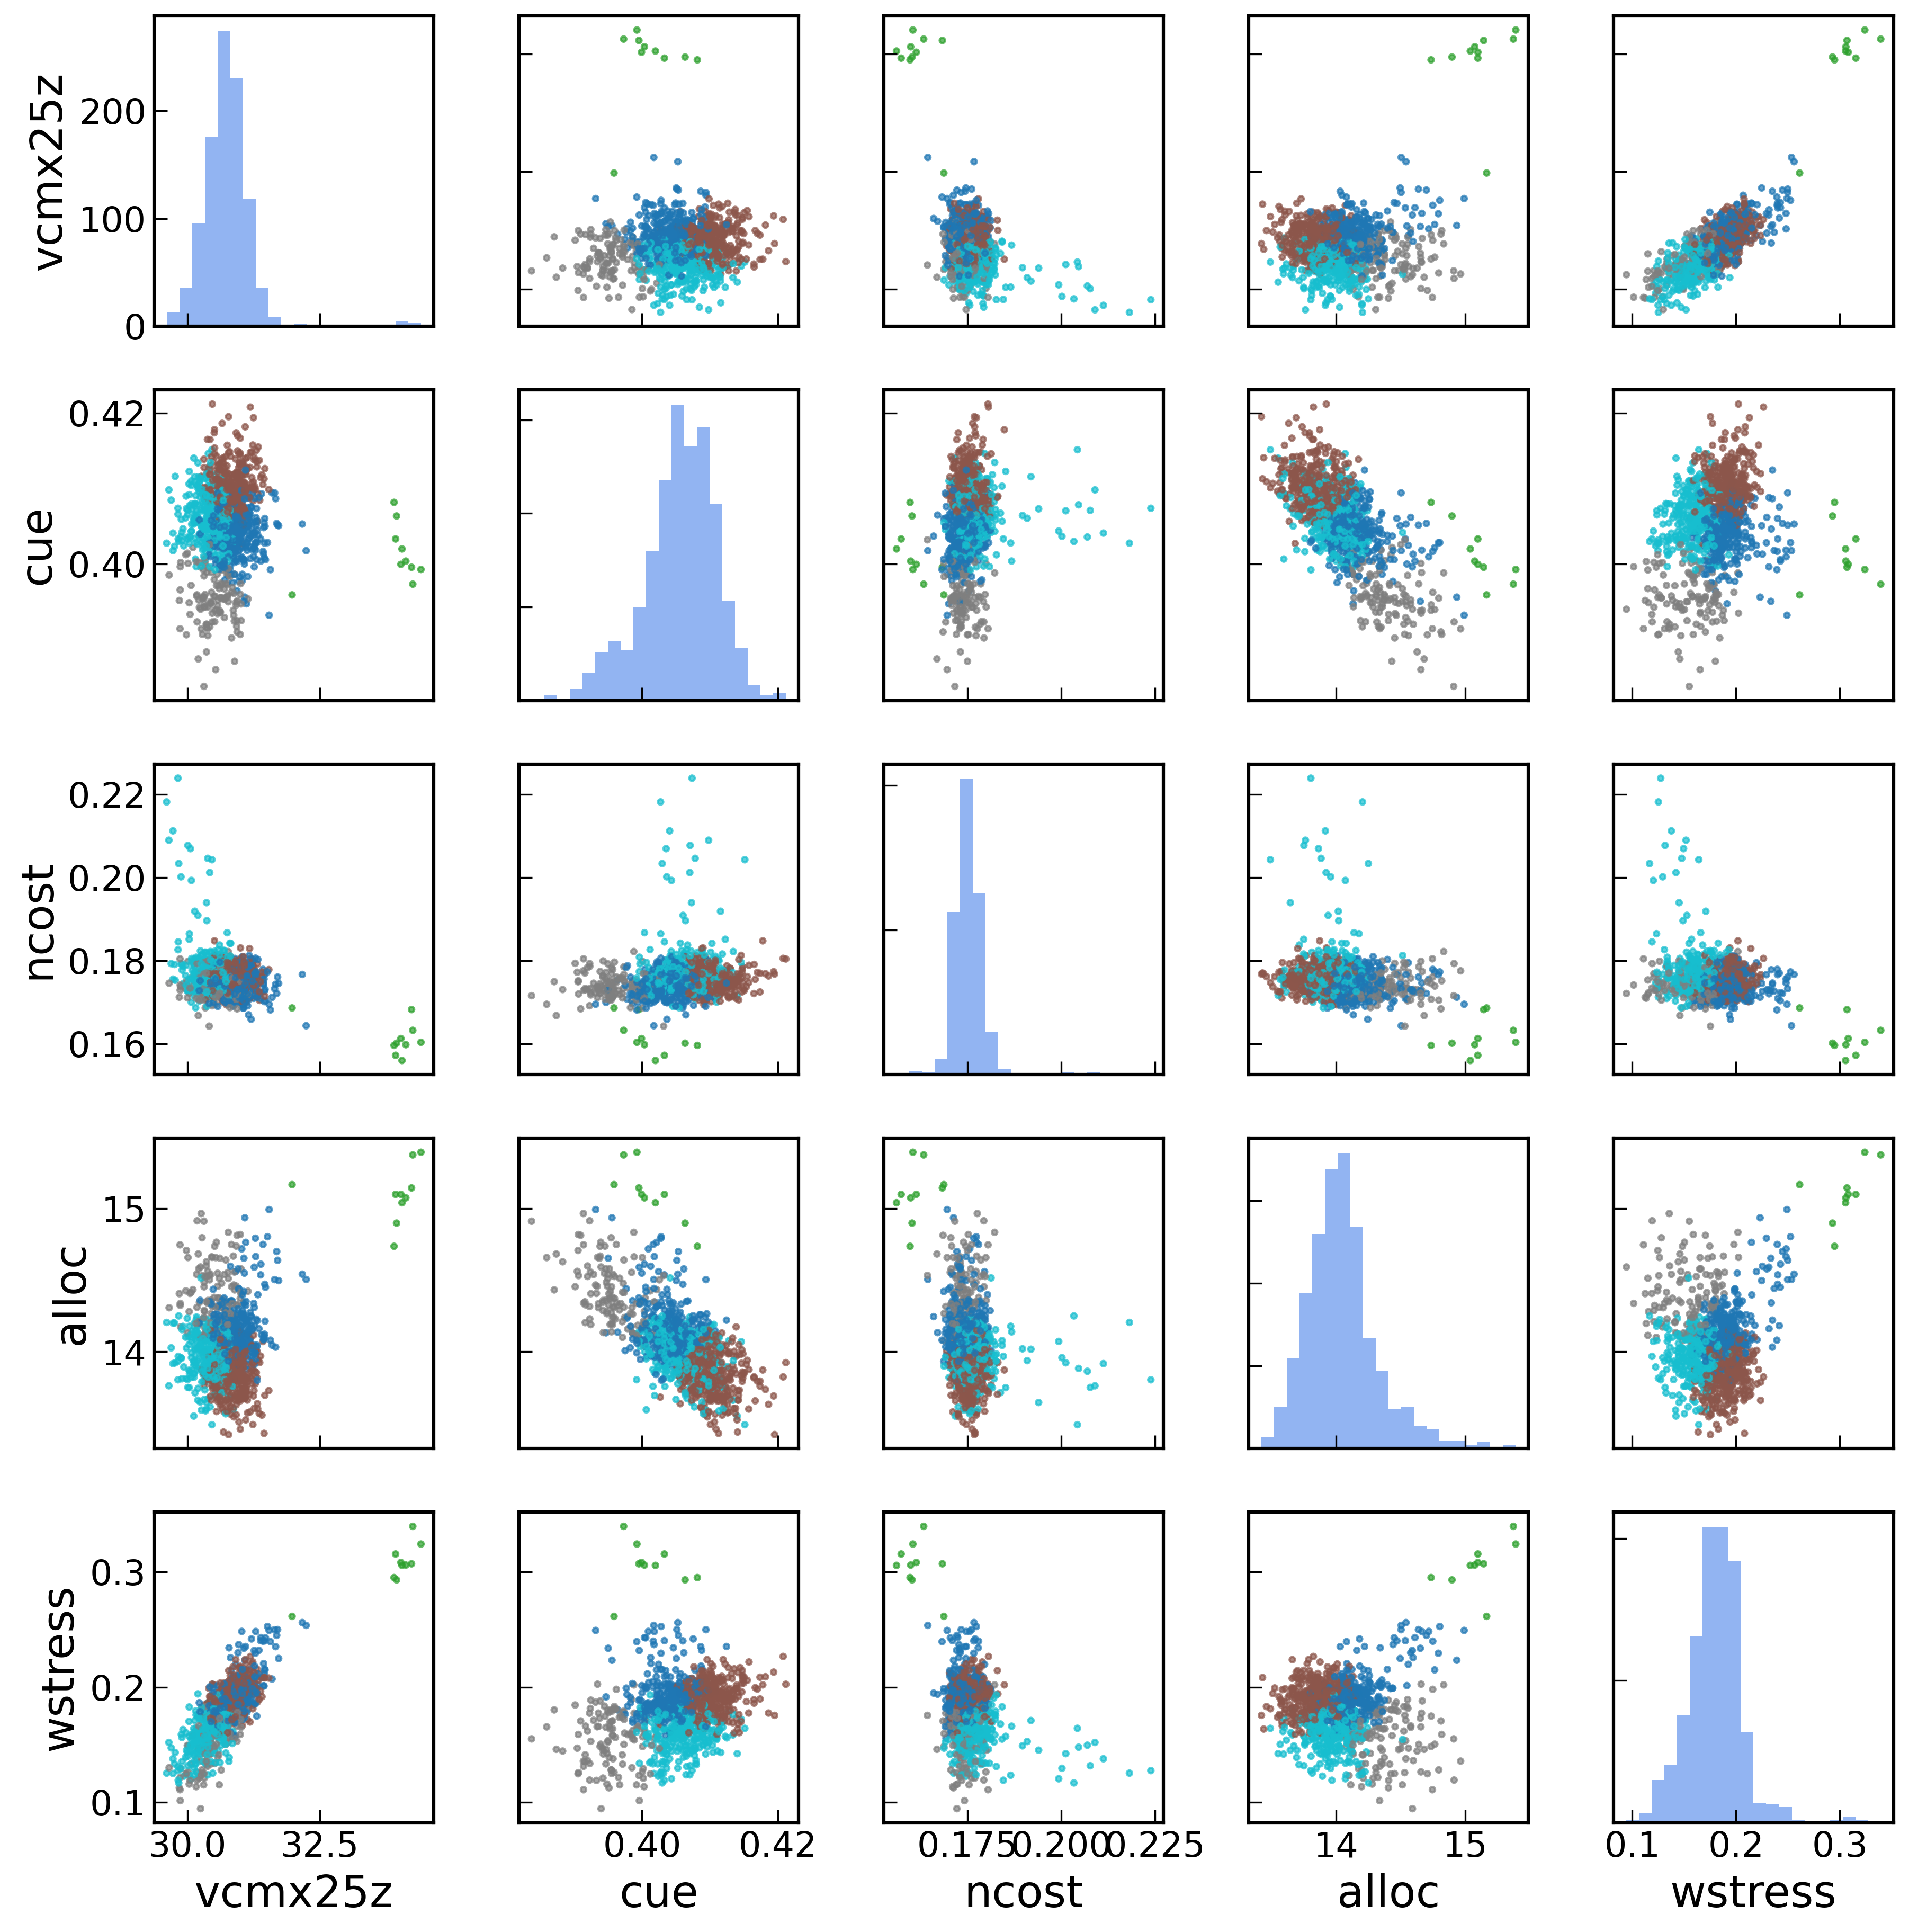

In [23]:
n_vars = X.shape[1]
fig, axes = plt.subplots(n_vars, n_vars, figsize=(2.5*n_vars, 2.5*n_vars))

for i in range(n_vars):
    for j in range(n_vars):
        ax = axes[i, j]
        if i == j:
            # Diagonal: histogram
            ax.hist(X[:, i], bins=20, color='cornflowerblue', alpha=0.7)
        else:
            # Off-diagonal: scatter
            ax.scatter(X[:, j], X[:, i], s=6, c=labels, cmap='tab10', alpha=0.7)
        # Only label outer axes
        if i < n_vars - 1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(vars[j])
        if j > 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(vars[i])

plt.tight_layout()
plt.savefig('./checkpoints_objective/clusters_Global_metricspace.png')

### Select parameter sets

In [24]:
labels = ds['cluster'].values
clusters = np.unique(labels)

# pick 2 random indices per cluster
selected_idxs = []
rng = np.random.default_rng(seed=0) 
for c in clusters:
    # find all sample-positions belonging to cluster c
    idxs = np.where(labels == c)[0]
    if len(idxs) >= 2:
        chosen = rng.choice(idxs, size=2, replace=False)
    else:
        # if fewer than 2 members, just take them all
        chosen = idxs
    selected_idxs.extend(chosen.tolist())

selected_idxs = np.array(selected_idxs, dtype=int)
print("Selected sample indices:", selected_idxs)


Selected sample indices: [863 669 301  96  37  93 817 661 451 582]


In [ ]:
samp.to_csv('caltest_103-107.csv')

### Plot posteriors of caltests

In [22]:
import matplotlib.cm as cm
import matplotlib.colors as colors
colors = [cm.viridis(i) for i in np.linspace(0, 1, 10)]

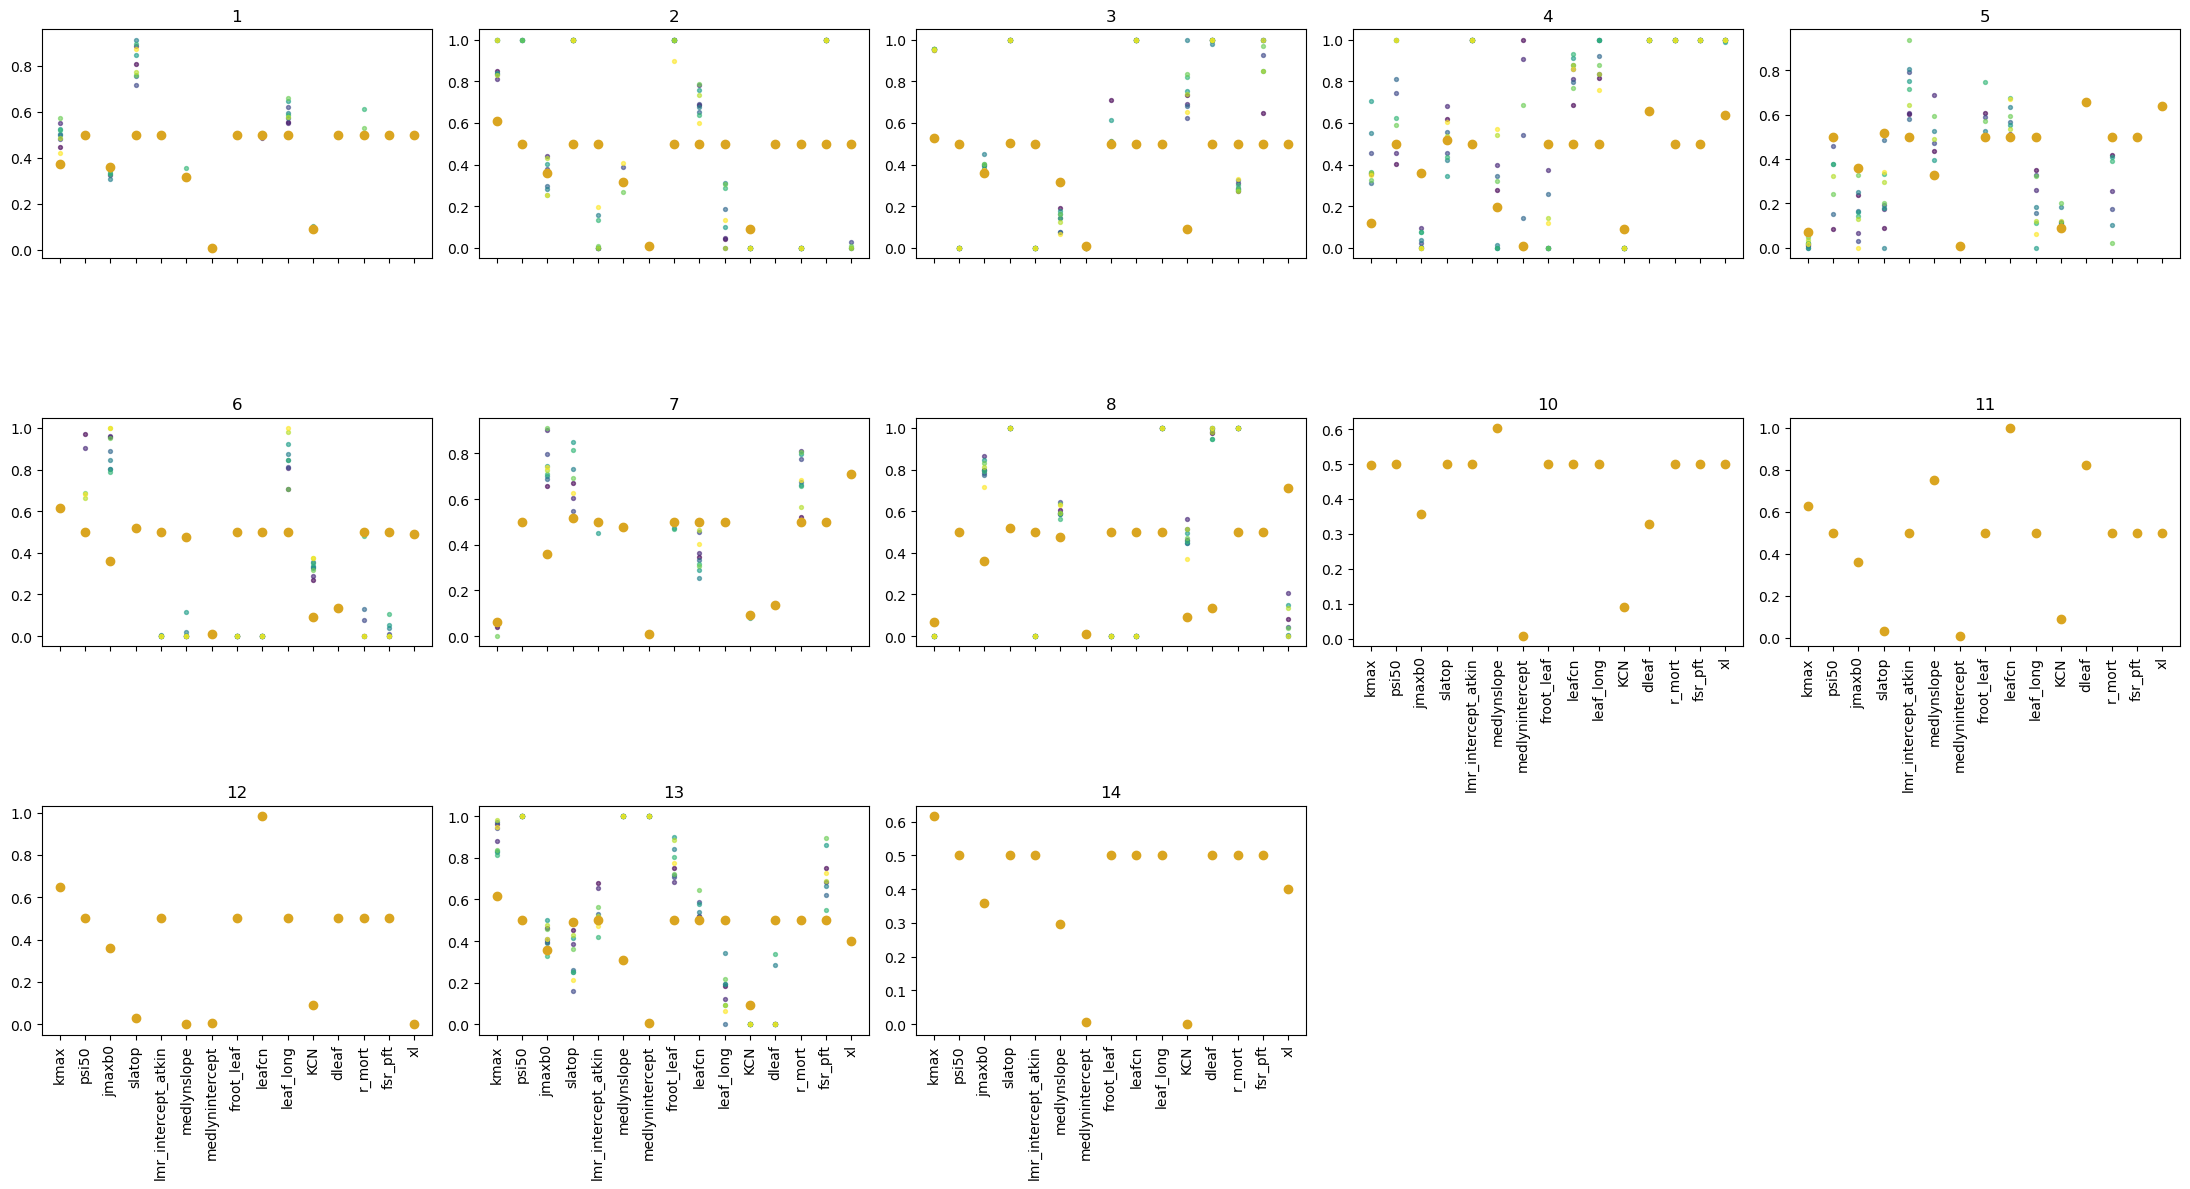

In [ ]:
plt.figure(figsize=(22, 12))
pft_ids = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14]
selected_paramsets = pd.read_csv('./paramsets/caltest_103-107.csv')
for j, pft in enumerate(pft_ids):
    plt.subplot(3, 5, j+1)
    pft_param_names = [f"{param}_{pft}" for param in pft_params]
    data = selected_paramsets[pft_param_names]

    # Plot dots instead of boxplots
    for i, col in enumerate(data.columns):
        # plot default value
        plt.plot(i + 1, default_params[col], 'o', color='goldenrod')

        # plot calibrated values
        x_vals = np.full_like(data[col], i + 1, dtype=float)
        for j in range(len(x_vals)):
            plt.scatter(x_vals[j], data[col].iloc[j], s=8, alpha=0.6,color = colors[j])

    if pft > 8:
        plt.xticks(ticks=np.arange(1, len(data.columns) + 1), labels=pft_params, rotation=90)
    else:
        plt.xticks(ticks=np.arange(1, len(data.columns) + 1), labels=[])

    plt.title(pft)

plt.tight_layout()
plt.savefig('./figs/caltest_103-107_posteriors.png', dpi=300)
